#### Session 0.0: introduce libraries, database path and main independent variable

In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy import stats
import scipy.stats as st
import h5py
from sorting_time_series_analysis import follow_behaviour_analysis
from preference_analysis import *
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from data_cleaning import findLongestConseqSubseq

In [2]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
#variable_name='mu'
variable_name='location'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump

In [ ]:
# def slices_lists(list1, list2,number,list3=[]):
#     list1=list1[:number]
#     list2=list2[:number]
#     list3=list3[:number]
#     return list1, list2, list3
# dir_list,vr_no,no_food=slices_lists(dir_list, vr_no, 26, no_food)

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [3]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","bifuration_vr_locust_sta_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    vr_no = vr_no.astype('int')
    no_food=animal_of_interest["Food retriction (-1 or the number of hours)"].values
    no_food =no_food.astype('int')
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [ ]:
dir_list=dir_list[:26]
vr_no=vr_no[:26] 
no_food=no_food[:26]

In [4]:
dir_list=dir_list[26:]
vr_no=vr_no[26:] 
no_food=no_food[26:]

### Session 1.1: introduce helper functions to make plot and calculate speed

In [5]:
analysis_methods.update({"plotting_trajectory": False})
analysis_methods.update({"save_output":True})

In [ ]:
relative_pos_all_animals=[]
raster_across_animals=[]
trial_evaluation_across_animals=[]
animal_id=0
for this_dir,this_vr,this_no_food in zip(dir_list,vr_no,no_food):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    summary_pattern = f"VR{this_vr}*score_full.h5"
    agent_file = find_file(Path(this_dir), agent_pattern)
    focal_animal_file = find_file(Path(this_dir), xy_pattern)
    summary_file = find_file(Path(this_dir), summary_pattern)
    relative_pos,trial_evaluation_list,raster_pd,num_unfilled_gap,_=follow_behaviour_analysis(summary_file,focal_animal_file,agent_file,analysis_methods)
    if animal_id==0:
        largest_unfilled_gap=num_unfilled_gap
    elif num_unfilled_gap>largest_unfilled_gap:
        largest_unfilled_gap=num_unfilled_gap
    else:
        pass
    relative_pos_all_animals.append(relative_pos)
    trial_evaluation=pd.concat(trial_evaluation_list)
    trial_evaluation.insert(0, 'VR',np.repeat(this_vr,trial_evaluation.shape[0]))
    trial_evaluation.insert(0, 'minimum_starvation_time',np.repeat(this_no_food,trial_evaluation.shape[0]))
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    trial_evaluation_across_animals.append(trial_evaluation)
    raster_pd.insert(0, 'animal_id', np.repeat(animal_id,raster_pd.shape[0]))
    raster_across_animals.append(raster_pd)
    animal_id=animal_id+1
analysis_methods['largest_unfilled_gap']= largest_unfilled_gap
plt.show()

### Session 2 quantify relative preference

#### Session 2.1 calculate relative distance to narrow down the definition of follow choices in this assay

In [7]:
## calculating the relative distance between the focal animal and other agents in every frame
relative_pos_all_pd=pd.concat(relative_pos_all_animals,ignore_index=True)
relative_pos_all_pd['distance']=relative_pos_all_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)

In [ ]:
## get trial type and sort them by the length of the name and then by alphabet. In this case, homogeneous trial should usually be the first twos
trial_type_list=sorted(relative_pos_all_pd['type'].unique(), key=len)
trial_type_list[2:]=sorted(trial_type_list[2:], key=str,reverse=True)
trial_type_list[:2]=sorted(trial_type_list[:2], key=str,reverse=True)
print(trial_type_list)
# trial_type_of_interest=[trial_type_list[0]]
# trial_type_of_interest=[trial_type_list[1]]
# trial_type_of_interest=[trial_type_list[2]]
# trial_type_of_interest=[trial_type_list[3]]
trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]

In [ ]:
for distance_threshold_for_plotting in range(5,30,10):
    print(f"distance threshold for plotting 2D histogram: {distance_threshold_for_plotting} cm")
    if len(trial_type_of_interest)==1:
        relative_pos_of_interest=[relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[0]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)]]
    elif len(trial_type_of_interest)==2:
        relative_pos_of_interest=[relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[0]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)],relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[1]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)]]
    plot_relative_pos_distribution(relative_pos_of_interest,trial_type_of_interest,distance_threshold_for_plotting,analysis_methods)

#### Session 2.2 calculate preference index based on the narrower definition of follow choices and plot the index

In [ ]:
#trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
left_right_preference_across_animals,exp_con_preference_across_animals,_,_=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,analysis_methods)

In [ ]:
plot_preference_index(left_right_preference_across_animals,exp_con_preference_across_animals,trial_type_of_interest,analysis_methods)

#### Session 2.3 plot relative position and calculate preference index VR rig by VR rig

In [ ]:
# plotting the preference index for each VR number
trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
plot_relative_position_groupby_vr=True
for this_vr in np.unique(vr_no):
    print(f"VR number {this_vr} is used in the experiment")
    ### next time, finish this function to plot relative position distribution for each VR number
    if plot_relative_position_groupby_vr==True:
        relative_pos_subgroups=[relative_pos_all_animals[x] for x in np.where(vr_no==this_vr)[0]]
        relative_pos_sub_pd=pd.concat(relative_pos_subgroups,ignore_index=True)
        relative_pos_sub_pd['distance']=relative_pos_sub_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)
        for distance_threshold_for_plotting in range(5,30,10):
            print(f"distance threshold for plotting 2D histogram: {distance_threshold_for_plotting} cm")
            if len(trial_type_of_interest)==1:
                relative_pos_of_interest=[relative_pos_sub_pd[(relative_pos_sub_pd['type']==trial_type_of_interest[0]) & (relative_pos_sub_pd['distance']<distance_threshold_for_plotting)]]
            elif len(trial_type_of_interest)==2:
                relative_pos_of_interest=[relative_pos_sub_pd[(relative_pos_sub_pd['type']==trial_type_of_interest[0]) & (relative_pos_sub_pd['distance']<distance_threshold_for_plotting)],relative_pos_sub_pd[(relative_pos_sub_pd['type']==trial_type_of_interest[1]) & (relative_pos_sub_pd['distance']<distance_threshold_for_plotting)]]
            plot_relative_pos_distribution(relative_pos_of_interest,trial_type_of_interest,distance_threshold_for_plotting,analysis_methods,this_vr=f"VR{this_vr}")
    if "left_right_preference_across_animals:" in locals():
        plot_preference_index(left_right_preference_across_animals[:,vr_no==this_vr],exp_con_preference_across_animals[:,vr_no==this_vr],trial_type_of_interest,analysis_methods,thresholds=[4,5,6,7,8],this_vr=f"VR{this_vr}")

In [ ]:
##do some correlation analysis to see if there is any correlation between the preference index and the travel distance or turning angles
##whether opened wing makes a difference in the travel distance
##analyse speed and follow duration after an animal start to follow the target (distance < 4 cm)

### Session 3 Calculate other metrics to look for any confounding factors in the dataset

Session 3.1: plot distribution trial by trial with seaborn and pandas

In [15]:
#convert the data type from list into a big concatenated pandas dataframe
all_evaluation=pd.concat(trial_evaluation_across_animals)

In [16]:
#turning metrics of interest into boolian values so that we can use them to filter or group the data
all_evaluation['longer_than_30']=all_evaluation['minimum_starvation_time']>30

In [17]:
#use cut function to chop the data into 3 groups based on the order of the animal ID so that we can group the data by day
all_evaluation['day_group'] = pd.cut(all_evaluation['animal_id'], bins=3, labels=['Day1', 'Day2', 'Day3'])

In [ ]:
sns.jointplot(data=all_evaluation, x="travel_distance_ISI", y="num_follow_epochs", hue="longer_than_30")
#sns.jointplot(data=all_evaluation, x="travel_distance", y="minimum_starvation_time")
#sns.regplot(data=all_evaluation, x='minimum_starvation_time', y='travel_distance')
plt.show()

Session 3.2: plot distribution animal by animal with seaborn and pandas agg function

In [ ]:
# a traditional way to summarise individual's variables is to use groupby function with a for-loop to go through every animal ID
# The benefit of this way is that we can do all kinds of analysis on the data
# but the downside is that it takes time to write down these codes 
travel_distance_all1=[]
turning_angle_all1=[]
travel_distance_all2=[]
turning_angle_all2=[]
travel_distance_all3=[]
turning_angle_all3=[]
graph_colour_code =analysis_methods.get("graph_colour_code")
print(graph_colour_code)
camera_fps=analysis_methods.get("camera_fps")
fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2 = axes.flatten()
for keys, grp in all_evaluation.groupby('animal_id'):
    travel_distance_aba=grp['travel_distance_ISI'].sum()+grp['travel_distance'].sum()
    # travel_distance_list.append(travel_distance_aba)
    turning_angle_aba=grp['total_turning_ISI'].sum()+grp['total_turning'].sum()
    # turning_angle_list.append(turning_angle_aba)
    if grp['day_group'].values[0] == 'Day1':
        this_color=graph_colour_code[0]
        travel_distance_all1.append(travel_distance_aba)
        turning_angle_all1.append(turning_angle_aba)
    elif grp['day_group'].values[0] == 'Day2':
        this_color=graph_colour_code[1]
        travel_distance_all2.append(travel_distance_aba)
        turning_angle_all2.append(turning_angle_aba)
    elif grp['day_group'].values[0] == 'Day3':   
        this_color=graph_colour_code[2]
        travel_distance_all3.append(travel_distance_aba)
        turning_angle_all3.append(turning_angle_aba)
    ax1.scatter(travel_distance_aba,turning_angle_aba,c=this_color,s=8)
travel_distance_arr1=np.hstack(travel_distance_all1)
turning_angle_arr1=np.hstack(turning_angle_all1)
travel_distance_arr2=np.hstack(travel_distance_all2)
turning_angle_arr2=np.hstack(turning_angle_all2)
travel_distance_arr3=np.hstack(travel_distance_all3)
turning_angle_arr3=np.hstack(turning_angle_all3)
ax1.scatter(np.mean(travel_distance_arr1),np.mean(turning_angle_arr1),c=graph_colour_code[0],s=50,marker='*')
ax1.scatter(np.mean(travel_distance_arr2),np.mean(turning_angle_arr2),c=graph_colour_code[1],s=50,marker='*')
ax1.scatter(np.mean(travel_distance_arr3),np.mean(turning_angle_arr3),c=graph_colour_code[2],s=50,marker='*')
plt.show()

In [ ]:
all_evaluation.columns

In [ ]:
# if the analysis you want to do to summarise individual animal's data is some simple operation like sum or mean, 
# Then you can use agg function of pandas to do the same thing as above
# The benefit of this way is that the end product is still a pandas dataframe so it is easy to make plots and do further analysis
aggregated_data = all_evaluation.groupby('animal_id').agg(
    total_travel_distance=('travel_distance_ISI', 'sum'),
    turning_angle=('gross_turning_ISI', 'sum'),
    num_follow_epochs=('num_follow_epochs', 'sum'),
    minimum_starvation_time=('minimum_starvation_time', 'first'),
    day_group=('day_group', 'first'),
    longer_than_30=('longer_than_30','first'),
    vr_no=('VR', 'first'),
)
print(aggregated_data)

In [19]:
# check if previous pd.cut function split the data correctly. If not, we can use the following code to assign the day_group manually
aggregated_data.loc[11, 'day_group']='Day2'
aggregated_data.loc[22, 'day_group']='Day3'

#### plotting tips: If the number of data to plot is smaller, try revealing the real distribution of the data and avoiding kde plot. In this case, instead of using jointplot function, use JoinGrid for the sake of flexibility

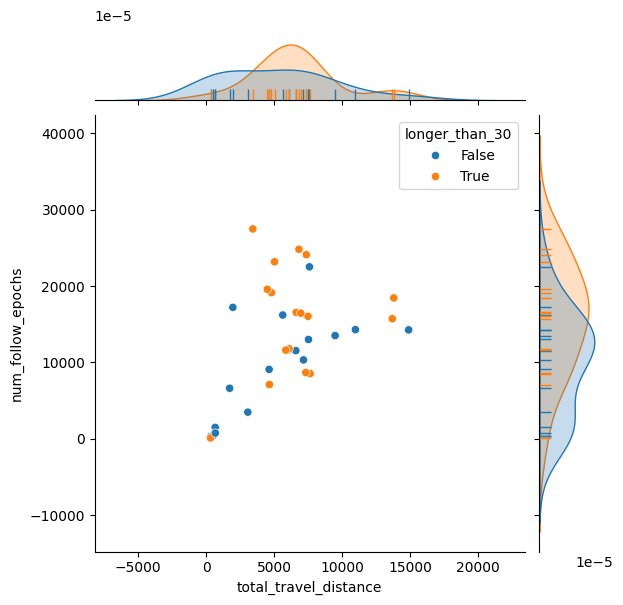

In [76]:
a=sns.jointplot(data=aggregated_data, x="total_travel_distance", y="num_follow_epochs", hue="longer_than_30")
## add an additional marginal plot to show the distribution of the data
a.plot_marginals(sns.rugplot, height=0.15, clip_on=False)

<Axes: xlabel='Count', ylabel='num_follow_epochs'>

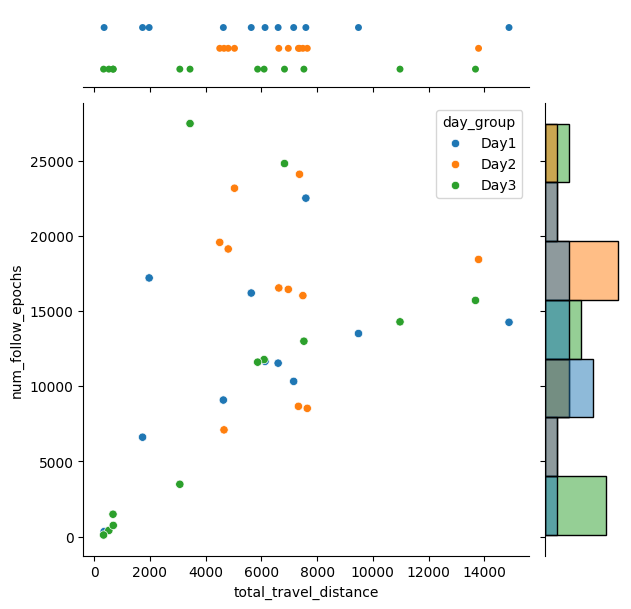

In [84]:
## creating an empty JoinGrid object gives you flexibility of every plots
b=sns.JointGrid()
x, y,h = aggregated_data["total_travel_distance"], aggregated_data["num_follow_epochs"], aggregated_data["day_group"]
sns.scatterplot(x=x,y=y,hue=h,ax=b.ax_joint)
sns.stripplot(x=x,hue=h,ax=b.ax_marg_x,dodge=True,legend=False,jitter=False)
sns.histplot(y=y,hue=h,ax=b.ax_marg_y,legend=False)

In [ ]:
## If an non-empty JoinGrid object is created, plot function can give you concise of the code (but only default parameters)
c = sns.JointGrid(data=aggregated_data, x="total_travel_distance", y="turning_angle",hue='vr_no')
c.plot(sns.scatterplot, sns.histplot)
c.refline(y=0)